# Reviews classification

#### Data loading

* review.json is 6.3 GB and only first 500.000 records will be loaded.

In [1]:
import json 
import numpy as np
import pandas as pd

In [2]:
data_size_review = 100000

with open("../yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
    review_head = [next(f) for x in range(data_size_review)]
f.close()

review_data = []
for line in review_head:
    review_data.append(json.loads(line))

df = pd.DataFrame(review_data)

print("%i records loaded from review.json, each composed by %i columns." % (df.shape[0], df.shape[1]))

100000 records loaded from review.json, each composed by 9 columns.


#### Data preview

In [3]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,-MhfebM0QIsKt87iDN-FNw,0,2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,2.0,"As someone who has worked with many museums, I...",5,OwjRMXRC0KyPrIlcjaXeFQ
1,lbrU8StCq3yDfr-QMnGrmQ,0,2013-12-07 03:16:52,1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,I am actually horrified this place is still in...,1,nIJD_7ZXHq-FX8byPMOkMQ
2,HQl28KMwrEKHqhFrrDqVNQ,0,2015-12-05 03:18:11,0,LG2ZaYiOgpr2DK_90pYjNw,5.0,I love Deagan's. I do. I really do. The atmosp...,1,V34qejxNsCbcgD8C0HVk-Q
3,5JxlZaqCnk1MnbgRirs40Q,0,2011-05-27 05:30:52,0,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0,ofKDkJKXSKZXu5xJNGiiBQ
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4.0,"Oh happy day, finally have a Canes near my cas...",0,UgMW8bLE0QMJDCkQ1Ax5Mg


In [471]:
size = 10000
train_size = int(size*0.8)
test_size = size-train_size
print(size, train_size)

(10000, 8000)


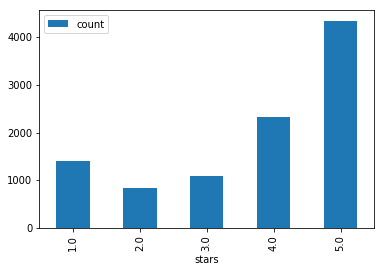

In [472]:
df_count = df[:size].groupby('stars')['stars'].agg(['count'])
df_count.plot.bar()

In [473]:
val_max = max(df_count.values)[0]
class_weights = {0: val_max/float(df_count.values[0][0]), 
                 1: val_max/float(df_count.values[1][0]), 
                 2: val_max/float(df_count.values[2][0]), 
                 3: val_max/float(df_count.values[3][0]), 
                 4: val_max/float(df_count.values[4][0])}
class_weights

{0: 3.0809084457061746,
 1: 5.161712247324614,
 2: 3.97163769441903,
 3: 1.8743523316062176,
 4: 1.0}

#### Building the prediction model

We want to build a deep neural network that can rate from 1 to 5 a review given in input. The model will be trained on the review data from Yelp Dataset, in which each review is associated to a star rank from 1 (bad) to 5 (good).

In [474]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [475]:
# to train the model we need (input, output) pairs: 
# sentences is the array of inputs and labels is the array of outputs.
sentences = []
for text in df.text:
    sentences.append(text)
    
labels = []
for star in df.stars:
    array = [0 for i in range(5)]
    array[int(star)-1] = 1
    labels.append(array)
    
print(len(sentences), len(labels))

(100000, 100000)


In [476]:
sentences = sentences[:size]
labels = labels[:size]

print(len(sentences), len(labels))

# split the data in (train_data, test_data)
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

train_labels = np.array(labels[:train_size])
test_labels = np.array(labels[train_size:])

print(np.shape(train_sentences), np.shape(test_sentences))
print(np.shape(train_labels), np.shape(test_labels))

(10000, 10000)
((8000,), (2000,))
((8000, 5), (2000, 5))


In [487]:
vocab_size = 10000
embedding_dim = 128
max_length = 256

In [508]:
# tokenization phase, may takes few minutes

tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences)
    
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(np.shape(train_padded))
print(np.shape(test_padded))

(7028, 256)
(1341, 256)


In [509]:
# compose the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 256, 128)          1280000   
_________________________________________________________________
global_average_pooling1d_54  (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 645       
Total params: 1,280,645
Trainable params: 1,280,645
Non-trainable params: 0
_________________________________________________________________


In [510]:
# train the model

from tensorflow.keras.callbacks import EarlyStopping

epochs = 500
history = []

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history.append(model.fit(np.array(train_padded), np.array(train_labels), epochs=epochs, 
                         #class_weight=class_weights,
                       validation_data=(test_padded, test_labels), verbose=2, callbacks=[es]))
model.save_weights('my_model_weights.h5')

Train on 7028 samples, validate on 1341 samples
Epoch 1/500
7028/7028 - 7s - loss: 1.3441 - accuracy: 0.4747 - val_loss: 1.1512 - val_accuracy: 0.5720
Epoch 2/500
7028/7028 - 5s - loss: 1.2453 - accuracy: 0.5087 - val_loss: 1.0828 - val_accuracy: 0.5884
Epoch 3/500
7028/7028 - 5s - loss: 1.1624 - accuracy: 0.5370 - val_loss: 0.9789 - val_accuracy: 0.6257
Epoch 4/500
7028/7028 - 6s - loss: 1.0595 - accuracy: 0.5693 - val_loss: 0.8679 - val_accuracy: 0.6726
Epoch 5/500
7028/7028 - 5s - loss: 0.9553 - accuracy: 0.6094 - val_loss: 0.7664 - val_accuracy: 0.7122
Epoch 6/500
7028/7028 - 5s - loss: 0.8668 - accuracy: 0.6463 - val_loss: 0.6851 - val_accuracy: 0.7256
Epoch 7/500
7028/7028 - 5s - loss: 0.7955 - accuracy: 0.6786 - val_loss: 0.6266 - val_accuracy: 0.7748
Epoch 8/500
7028/7028 - 5s - loss: 0.7366 - accuracy: 0.7080 - val_loss: 0.5730 - val_accuracy: 0.7919
Epoch 9/500
7028/7028 - 5s - loss: 0.6862 - accuracy: 0.7325 - val_loss: 0.5365 - val_accuracy: 0.8136
Epoch 10/500
7028/7028 - 

In [511]:
# evaluate the model

_, train_acc = model.evaluate(np.array(train_padded), np.array(train_labels), verbose=0)
_, test_acc = model.evaluate(test_padded, test_labels, verbose=0)
print('Train: %.1f%%, Test: %.1f%%' % (train_acc*100, test_acc*100))
train_ratio = float(train_size)/size
print('Average: %.1f%%' % float((train_acc*train_ratio + test_acc*(1-train_ratio))*100))

Train: 99.3%, Test: 89.3%
Average: 97.3%


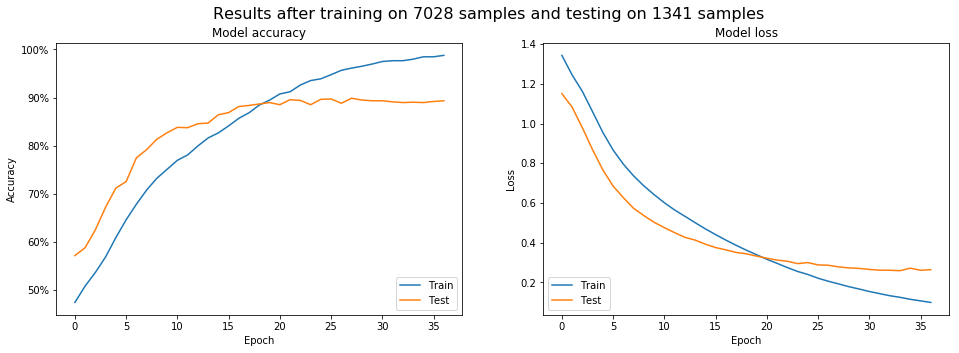

In [512]:
# print results

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


for i in range(len(history)):

    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('Results after training on %i samples and testing on %i samples' 
                 % (len(train_padded), len(test_padded)), fontsize=16)

    # summarize history for accuracy
    axes[0].plot(history[i].history['accuracy'])
    axes[0].plot(history[i].history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='lower right')

    # summarize history for loss
    axes[1].plot(history[i].history['loss'])
    axes[1].plot(history[i].history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='lower left')

    plt.show()

In [514]:
# make prediction

sentences_p = [
    "Horrible, this is a bad place. Disgusting",
    "I recommend to all to have a dinner here!"
]

sequences_p = tokenizer.texts_to_sequences(sentences_p)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')

result = model.predict(padded_p)

for i in range(len(result)):
    print('"%s" rating prediction is:' % sentences_p[i])
    tmp = []
    for j in range(5):
        tmp.append((result[i][j], j+1))
    tmp = sorted(tmp, key=lambda el: -el[0])
    for j in range(5):
        print('%.0f%% probability %i star.' % (tmp[j][0]*100, tmp[j][1]))

"Horrible, this is a bad place. Disgusting" rating prediction is:
92% probability 1 star.
3% probability 5 star.
2% probability 2 star.
2% probability 4 star.
2% probability 3 star.
"I recommend to all to have a dinner here!" rating prediction is:
70% probability 5 star.
19% probability 4 star.
9% probability 1 star.
2% probability 3 star.
1% probability 2 star.


In [504]:
train_losses = []
test_losses = []

for i in range(len(train_padded)):
    print '\r Progress: ' + str(round(float(i+1)/len(train_padded)*100, 2)) + "%",
    loss, _ = model.evaluate(np.array([train_padded[i]]), np.array([train_labels[i]]), verbose=0)
    train_losses.append([i, loss])

train_losses = sorted(train_losses, key=lambda el: -el[1])

for i in range(len(test_padded)):
    print '\r Progress: ' + str(round(float(i+1)/len(test_padded)*100, 2)),
    loss, _ = model.evaluate(np.array([test_padded[i]]), np.array([test_labels[i]]), verbose=0)
    test_losses.append([i, loss])

test_losses = sorted(test_losses, key=lambda el: -el[1])

 Progress: 100.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

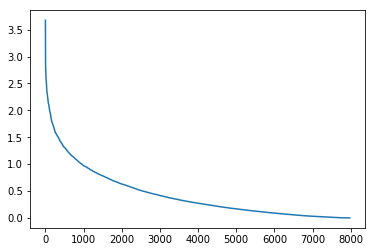

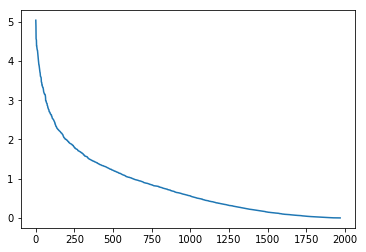

In [506]:
plt.plot([el[1] for el in train_losses])
plt.show()
plt.plot([el[1] for el in test_losses])
plt.show()

In [507]:
remove_indices = list([el[0] for el in filter(lambda el: el[1] > 1, train_losses)])
remove_indices = sorted(remove_indices, reverse=True)

train_sentences = [el for i, el in enumerate(train_sentences) if i not in remove_indices]
train_labels = np.array([el for i, el in enumerate(train_labels) if i not in remove_indices])

remove_indices = list([el[0] for el in filter(lambda el: el[1] > 1, test_losses)])
remove_indices = sorted(remove_indices, reverse=True)

test_sentences = [el for i, el in enumerate(test_sentences) if i not in remove_indices]
test_labels = np.array([el for i, el in enumerate(test_labels) if i not in remove_indices])
    
print(np.shape(train_sentences), np.shape(train_labels))
print(np.shape(test_sentences), np.shape(test_labels))

((7028,), (7028, 5))
((1341,), (1341, 5))


In [ ]:
sequences_p = tokenizer.texts_to_sequences(train_sentences)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
result = model.predict(padded_p)

correct = 0
error1 = 0
error2 = 0
for i in range(len(result)):
    pred = round(result[i]*5)
    real = round(train_labels[i]*5)
    if pred == real:
        correct = correct + 1
    elif abs(pred-real) == 1:
        error1 = error1 + 1
    elif abs(pred-real) == 2:
        error2 = error2 + 1

print('Accuracy on train data: %f.' % (float(correct)/float(len(train_sentences))*100))
print('Error 1 on train data: %f.' % (float(error1)/float(len(train_sentences))*100))
print('Error 2 on train data: %f.' % (float(error2)/float(len(train_sentences))*100))


sequences_p = tokenizer.texts_to_sequences(test_sentences)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
result = model.predict(padded_p)

correct = 0
error1 = 0
error2 = 0
error3 = 0
for i in range(len(result)):
    pred = round(result[i]*5)
    real = round(train_labels[i]*5)
    if pred == real:
        correct = correct + 1
    elif abs(pred-real) == 1:
        error1 = error1 + 1
    elif abs(pred-real) == 2:
        error2 = error2 + 1
    elif abs(pred-real) == 3:
        error3 = error3 + 1

print('Accuracy on test data: %f.' % (float(correct)/float(len(test_sentences))*100))
print('Error 1 on test data: %f.' % (float(error1)/float(len(test_sentences))*100))
print('Error 2 on test data: %f.' % (float(error2)/float(len(test_sentences))*100))
print('Error 3 on test data: %f.' % (float(error3)/float(len(test_sentences))*100))

In [ ]:
# try dropout to improve results

def dropout(sentence, label):
    sequences_p = tokenizer.texts_to_sequences([sentence])
    padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
    result = model.predict(padded_p)
    return round(result[0][0]*5) == label*5

print(dropout(train_sentences[0], train_labels[0]))